In [0]:
!pip install requests
!pip install bs4
!pip install selenium
!pip install user_agents
!pip install flask
!pip install pyautogui

import requests

import webbrowser
from bs4 import BeautifulSoup
from flask import request
import selenium
from user_agents import parse


In [0]:
import pyautogui
import time

def get_url():
  #click anywhere on the webpage to focus on the tab
  pyautogui.click(0,200)
  #in case the location clicked was a link object, wait until page refreshes
  time.sleep(4)
  pyautogui.press('f6')
  pyautogui.hotkey('ctrl', 'c')
  #get the copied url from the clipboard and pass it through to the
  #news_summarizer function
  url = pyperclip.paste()
  #news_summarizer(url)
  return url

In [0]:


def news_summarizer(url):
    article = ""
    #calls a response type object from the URL given.
    page = requests.get(url)
    #parse the HTML from the response object with BeautifulSoup's html parser
    soup = BeautifulSoup(page.content, 'html.parser')
    #first try to find all tags with <p/> that have a "c-article body text" class, this will filter all text
    # not related to the article. If the page is not structured with such id, just parse all <p/> tags.
    #try:

    
    exception1 = "cnn.com"
    exception2 = "thestar.com"
    exception3 = "bbc.com"
    exception4 = "economist.com"
    exception5 = "usatoday.com"
    exception6 = "politico.com"


    #If CNN article:
    if exception1 in url:
      paragraphs = soup.find_all('div', "zn-body__paragraph")

    #if the Toronto Star article:
    elif exception2 in url:
      paragraphs = soup.find_all('p', "text-block-container")
    
    #if BBC article:
    elif exception3 in url:
      paragraphs = soup.find_all('div', 'lx-stream-post-body' )

    #if Economist article:
    elif exception4 in url:
      paragraphs = soup.find_all('p', 'article__body-text')
    
    #if USAToday article:
    elif exception5 in url:
      paragraphs = soup.find_all('p', 'gnt_ar_b_p')

    elif exception6 in url:
      paragraphs = soup.find_all('p', ' story-text__paragraph')
    

    

# Generic case
    else:
    # If just about any other news site:
     paragraphs = soup.find_all('p')
  
    #concatenate all paragraphs together into one large string to pass through to the mode
    for paragraph in paragraphs:
        #drop all HTML tags and convert to string
        paragraph = paragraph.get_text()
        if ("." in paragraph):
            article += paragraph
    print((article))
    print(len(article))
    return article
  


In [0]:
url = "https://www.politico.com/news/2020/01/22/flynn-attorneys-argue-against-jail-time-for-former-national-security-adviser-102164"
news_summarizer(url)

Former national security adviser Michael Flynn should get probation and no jail time if he’s sentenced next month on a felony false-statement charge he pleaded guilty to in special counsel Robert Mueller’s investigation, Flynn’s lawyers told a federal judge Wednesday.Attorneys for Flynn argued in a new court filing that he deserves leniency for his more than three decades of Army service before taking a top job in President Donald Trump’s White House. The former three-star general’s tenure in the Trump administration was short-lived after he wound up in the crosshairs of investigators for his statements to the FBI in the early stages of its investigation into links between the Trump campaign and Russia.“Mr. Flynn dedicated his life to serving his country,” Flynn lawyer Sidney Powell and her co-counsel wrote. “While the defendants in other cases cited by the government were working to benefit themselves, Mr. Flynn wrote a blank check on his life and put himself in harm’s way for more th

'Former national security adviser Michael Flynn should get probation and no jail time if he’s sentenced next month on a felony false-statement charge he pleaded guilty to in special counsel Robert Mueller’s investigation, Flynn’s lawyers told a federal judge Wednesday.Attorneys for Flynn argued in a new court filing that he deserves leniency for his more than three decades of Army service before taking a top job in President Donald Trump’s White House. The former three-star general’s tenure in the Trump administration was short-lived after he wound up in the crosshairs of investigators for his statements to the FBI in the early stages of its investigation into links between the Trump campaign and Russia.“Mr. Flynn dedicated his life to serving his country,” Flynn lawyer Sidney Powell and her co-counsel wrote. “While the defendants in other cases cited by the government were working to benefit themselves, Mr. Flynn wrote a blank check on his life and put himself in harm’s way for more t

In [0]:
!pip install pytorch-transformers

In [0]:
import torch
from pytorch_transformers import XLNetConfig, XLNetTokenizer, XLNetModel

#XLNetModel
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
xlnet_model = XLNetModel.from_pretrained('xlnet-large-cased')
xlnet_model.eval()


In [0]:
#KMeans clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#Sentence tokenization
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#get article content CHANGE TO WEBSCRAPER
#sentence tokenization
article_sentences=sent_tokenize(news_summarizer("https://www.theglobeandmail.com/world/us-politics/article-us-senate-opens-president-trumps-impeachment-trial/"))

article_sentences

In [0]:
#Function get_article_encodings() - encodes article sentences using xlnet, xlnetlmhead, or bert
def get_article_encodings(article_sentences, encoding_tokenizer, encoding_model):
  article_encodings=[]
  for sentence in article_sentences:
    input_ids = torch.tensor(encoding_tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
    outputs = encoding_model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    #print(last_hidden_states.shape, type(last_hidden_states), last_hidden_states)
    mean_last_hidden_states = last_hidden_states.mean(-2)
    #print(mean_last_hidden_states.shape, type(mean_last_hidden_states), mean_last_hidden_states)
    article_encodings.append(mean_last_hidden_states.data)
  article_encodings = torch.stack(article_encodings)
  article_encodings = torch.squeeze(article_encodings, dim=1)
  print(article_encodings.shape, type(article_encodings), article_encodings)
  return article_encodings

In [0]:
#Function cluster_article_encodings - clusters article sentences encoding to ceiling of the sqrt of the number of article sentences
# and returns the sentences that are closest to the centroid of each cluster
def cluster_article_encodings(article_sentences, article_encodings, n=3):
  n_clusters = int(np.ceil(len(article_sentences)**0.5))
  print(n_clusters)
  kmeans = KMeans(n_clusters=n_clusters, random_state=0)
  kmeans = kmeans.fit(article_encodings)
  y_kmeans = kmeans.predict(article_encodings)
  print(y_kmeans)
  avg = []
  closest = []
  for j in range(n_clusters):
    idx = np.where(kmeans.labels_ == j)[0]
    avg.append(np.mean(idx))
  closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, article_encodings)
  ordering = sorted(range(n_clusters), key=lambda k: avg[k])
  summary = '\n'.join([article_sentences[closest[idx]] for idx in ordering])
  print(summary)
  return kmeans, y_kmeans, summary

In [0]:
#Function plot_clusters - plots the clusters
def plot_clusters(article_encodings, kmeans, y_kmeans):
  plt.scatter(article_encodings[:, 0], article_encodings[:, 1], c=y_kmeans, s=50, cmap='viridis')
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

torch.Size([21, 1024]) <class 'torch.Tensor'> tensor([[ 0.1873,  0.4511, -0.0031,  ..., -0.1462, -1.0672,  0.7276],
        [ 0.4640,  0.4578, -0.2048,  ...,  0.2254, -0.3387,  0.7448],
        [ 0.2108,  0.3639,  0.2266,  ...,  0.0444, -1.2032,  0.6865],
        ...,
        [ 0.6406,  0.7179,  0.3008,  ..., -1.9025,  1.2160,  2.7828],
        [-1.1756,  1.3824,  0.6392,  ...,  0.4552, -1.8172,  2.6404],
        [ 0.1188,  0.6210,  0.8810,  ...,  0.0696,  0.3285, -0.0542]])
5
[0 0 1 1 0 3 1 3 3 3 1 0 0 3 3 1 1 3 4 2 0]
The U.S. Senate has begun the third presidential impeachment trial in American history, weighing accusations that Donald Trump violated the Constitution by orchestrating a campaign to push Ukraine to interfere in this year’s election.Hours before proceedings got under way in the Capitol on Thursday, a congressional watchdog concluded that the White House broke the law by withholding military aid to Kyiv to crank up the pressure.Ukraine, for its part, announced it would 

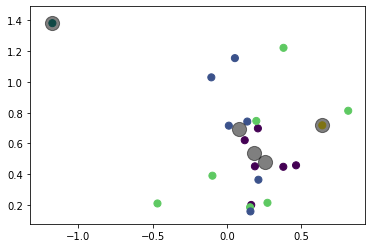

In [0]:
#trying xlnet_model
article_encodings = get_article_encodings(article_sentences, xlnet_tokenizer, xlnet_model)
kmeans, y_kmeans, summary = cluster_article_encodings(article_sentences, article_encodings)
plot_clusters(article_encodings, kmeans, y_kmeans)

In [0]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 72.7 MB of archives.
After this operation, 259 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 79.0.3945.79-0ubuntu0.18.04.1 [1,079 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 79.0.3945